## 52주 신고가

주제: 52주 신고가의 발생빈도

1. 기간: 2000-01-01 ~ 2017-12-31
2. 대상: 코스피 지수 및 코스닥 지수 

In [133]:
import pandas as pd
import numpy as np
import cx_Oracle as cxo
import matplotlib.pyplot as plt

%matplotlib inline

### Data Loading

In [10]:
conn = cxo.connect(user = 'ufngdba', password = 'venus2002', dsn = 'realdb')

kr_idx_sql = """
select TRD_DT, U_CD, STRT_PRC, 
        HIGH_PRC, LOW_PRC, CLS_PRC
from FNS_UD
where trd_dt between '20000101' and '20171231' and 
u_cd in ('I.001', 'I.101')
"""

kr_idx_data = pd.read_sql(kr_idx_sql, conn, index_col = 'TRD_DT')
kr_idx_data.index = pd.to_datetime(kr_idx_data.index)
kpi_tr = kr_idx_data['U_CD'] == 'I.001' ## KOSPI
kdq_tr = kr_idx_data['U_CD'] == 'I.101' ## KOSDAQ

kpi_idx_data = kr_idx_data[kpi_tr].drop('U_CD', axis = 1) ## KOSPI
kdq_idx_data = kr_idx_data[kdq_tr].drop('U_CD', axis = 1) ## KOSDAQ

### 각 년도별 데이터 개수

### KOSPI

In [15]:
kpi_idx_data['CLS_PRC'].resample('A').count()

TRD_DT
2000-12-31    241
2001-12-31    246
2002-12-31    244
2003-12-31    247
2004-12-31    249
2005-12-31    249
2006-12-31    247
2007-12-31    246
2008-12-31    248
2009-12-31    253
2010-12-31    251
2011-12-31    248
2012-12-31    248
2013-12-31    247
2014-12-31    245
2015-12-31    248
2016-12-31    246
2017-12-31    243
Freq: A-DEC, Name: CLS_PRC, dtype: int64

In [18]:
(kpi_idx_data['CLS_PRC'].resample('A').count()).mean()

247.0

### 52주 신고가를 247일로 가정하여 산출하도록 함.

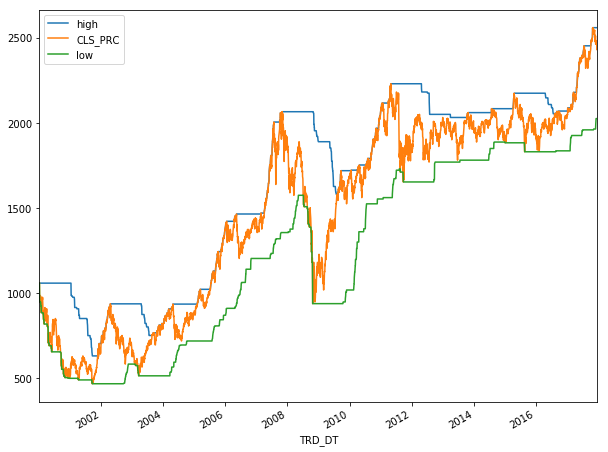

In [11]:
kpi_52_h = (kpi_idx_data['CLS_PRC'].rolling(window = 247, min_periods = 1).max()).rename('high')
kpi_52_l =( kpi_idx_data['CLS_PRC'].rolling(window = 247, min_periods = 1).min()).rename('low')

fig, ax = plt.subplots()
fig.set_size_inches((10, 8))

kpi_52_h.plot(ax = ax)
kpi_idx_data['CLS_PRC'].plot(ax = ax)
kpi_52_l.plot(ax = ax)

plt.legend()

### Columns - 52 Week High Or Low

In [26]:
kpi_idx_data['52_h'] = kpi_52_h
kpi_idx_data['52_l'] = kpi_52_l

2001년부터 2017년까지 52주 신고가 돌파

In [30]:
## 2000-01-04 / Lookback Bias
kpi_h_d = kpi_idx_data[['CLS_PRC', '52_h']]\
            .loc['2000-01-05':]
kpi_h_d_t = kpi_h_d['CLS_PRC'] == kpi_h_d['52_h']
kpi_h_d[kpi_h_d_t].head()

,CLS_PRC,52_h
TRD_DT,,
2001-11-23,645.18,645.18
2001-11-26,674.56,674.56
2001-12-05,688.31,688.31
2001-12-07,704.50,704.50
2002-01-02,724.95,724.95


In [37]:
kpi_trd_52h_day = kpi_h_d[kpi_h_d_t]['52_h'].resample('A').count()
kpi_trd_52h_day

TRD_DT
2001-12-31     4
2002-12-31    26
2003-12-31    16
2004-12-31    19
2005-12-31    67
2006-12-31    11
2007-12-31    51
2008-12-31     0
2009-12-31    14
2010-12-31    44
2011-12-31    14
2012-12-31     0
2013-12-31     5
2014-12-31     2
2015-12-31     8
2016-12-31     5
2017-12-31    49
Freq: A-DEC, Name: 52_h, dtype: int64

신고가 달성이 가장 많았던 시기는 2005년으로 67번의 신고가 갱신이 이루어졌음. 또한 2007년은 51번의 신고가 상승이 이루어지며 2005년의 뒤를 이었음. 한편 2017년의 경우 49번으로 2001년부터 2017년간 3번째로 많은 신고가 갱신을 보여주었음.

## 거래일별 비중.

각 해마다 거래일이 다를 수 있으므로 이를 반영하는 것이 필요. 예를들면 2017년 10월간 휴일은 약 10일 정도 있었음. 이를 반영하는 것이 필요함.

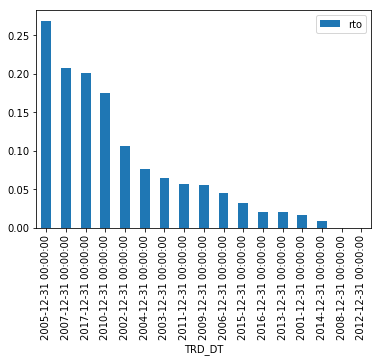

In [43]:
fig, ax = plt.figure

kpi_trd_day = ((kpi_idx_data['52_h']\
                .resample('A')\
                .count())\
                .loc['2001-12-31':]).rename('kpi_tr')
kpi_trd_day_rto = (pd.concat([kpi_trd_52h_day, kpi_trd_day], axis = 1))\
                    .assign(rto =kpi_trd_52h_day.div(kpi_trd_day))\
                    .drop(['52_h', 'kpi_tr'], axis = 1)
        
kpi_trd_day_rto.sort_values('rto', ascending = False).plot(kind = 'bar')

In [45]:
kpi_trd_day_rto.sort_values('rto', ascending = False)

,rto
TRD_DT,
2005-12-31,0.269076
2007-12-31,0.207317
2017-12-31,0.201646
2010-12-31,0.175299
2002-12-31,0.106557
2004-12-31,0.076305
2003-12-31,0.064777
2011-12-31,0.056452
2009-12-31,0.055336


## 52주 신고가 갱신 후 수익률

In [51]:
kpi_52h_day_idx = (kpi_h_d[kpi_h_d_t]['52_h']).index ## 52주 신고가 갱신 후 날짜

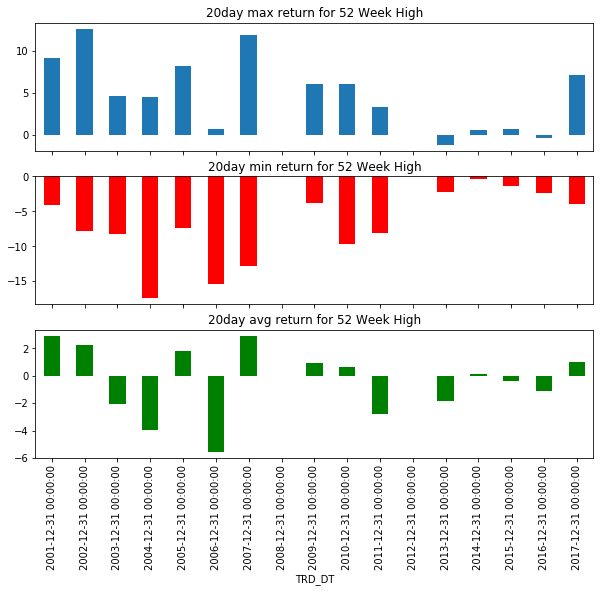

In [202]:
## 영업일 3일 수익률
fig, (ax, ax1, ax2) = plt.subplots(nrows = 3, ncols = 1, sharex= True)
fig.set_size_inches((10, 8))


a_2 = (kpi_h_d['CLS_PRC'][kpi_h_d_t]).rename('org')
kpi_idx_cls_n = ((kpi_h_d['CLS_PRC'].shift(-20))[kpi_h_d_t]).rename('nday_rt')
a_3 = pd.concat([a_2, kpi_idx_cls_n], axis = 1)
a_4 = ((a_3['nday_rt'] / a_3['org']).sub(1)).div(1/100)
(a_4.resample('A').max().rename('max')).plot(kind = 'bar', ax = ax, title = '20day max return for 52 Week High')
(a_4.resample('A').min().rename('min')).plot(kind = 'bar', ax = ax1, color = 'red', title = '20day min return for 52 Week High')
(a_4.resample('A').mean().rename('mean')).plot(kind = 'bar', ax = ax2, color = 'green', title = '20day avg return for 52 Week High')



fig.savefig('a_4.png')

### Momentum Score

In [192]:
def rt_plus(x):
    if x >= 1:
        ans = True
    else:
        ans = False
    return ans


def mnt_score(data, per = 1):
    
    mnt_score_1 = (data\
                    .pct_change()\
                    .dropna()\
                    .sub(-1)\
                    .resample('M')\
                    .prod())\
                    .apply(rt_plus)\
                    .rolling(per)\
                    .sum()
                
    name = "scr"+str(per)+"M"
    
    return mnt_score_1.rename(name)


mnt_scr = pd.concat([mnt_score(kpi_idx_cls),
           mnt_score(kpi_idx_cls, 3), 
           mnt_score(kpi_idx_cls, 6), 
           mnt_score(kpi_idx_cls, 12)], axis = 1)\
          .shift(1).dropna(how = 'all')

mnt_scr[(mnt_scr['scr1M'] == 1) & (mnt_scr['scr12M'] > 8)]

,scr1M,scr3M,scr6M,scr12M
TRD_DT,,,,
2002-04-30,1.0,3.0,6.0,9.0
2004-02-29,1.0,3.0,5.0,9.0
2004-03-31,1.0,3.0,5.0,10.0
2005-08-31,1.0,3.0,4.0,9.0
2007-06-30,1.0,3.0,5.0,9.0
2007-07-31,1.0,3.0,5.0,10.0
2007-08-31,1.0,3.0,6.0,10.0
2007-10-31,1.0,2.0,5.0,9.0
2007-11-30,1.0,2.0,5.0,10.0
